In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.utils.data as data

import pyro
from pyro.nn import PyroModule, PyroParam, PyroSample
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer.autoguide.initialization import init_to_mean, init_to_median, init_to_sample

from modules.config import read_config
from modules.datageneration import load_data, data_functions

from src import generate, train, eval
import os

from torch.utils.data import random_split, TensorDataset
from torch.utils.data.dataloader import DataLoader

import tyxe
import tyxe.util as util

import pickle

In [3]:
BASE_DIR = "../tests/sanity_check"
PROFILE = "tyxe-test"

In [4]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]
dataset_config["SIGMA"] = "0.3"
dataset_config["DATA_FUNC"] = "onedim_linear"
dataset_config["IN_DOMAIN_SAMPLE_SPACE"] = "(-5, 5)"
dataset_config["OUT_DOMAIN_SAMPLE_SPACE"] = "(-10, 10)"
dataset_config["TRAIN_SIZE"] = "1000"
dataset_config["TEST_SIZE"] = "1000"

====== Generating profile sin-(10,20)-10k ======
Train: (-5, 5)
Y-space: -1.7815442136201953 - 4.152500127025733
In Domain: (-5, 5)
Y-space: -2.2181150369115303 - 3.9697080345008438
Out Domain: (-10, 10)
Y-space: -4.599735575697779 - 6.855740432452966


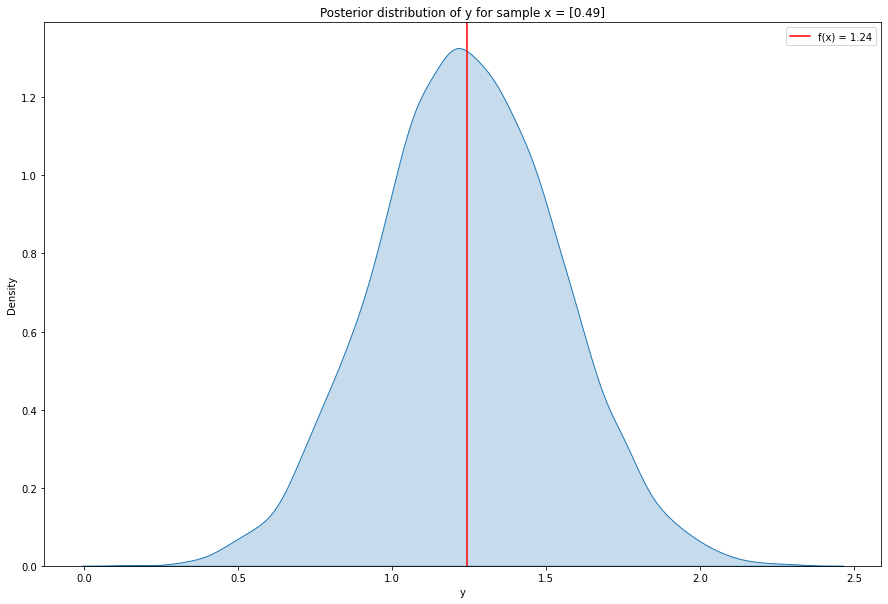

In [5]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [6]:
(x_train, y_train), _, (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_val=False)
x_test, y_test = torch.vstack((x_test_in_domain, x_test_out_domain)), torch.vstack((y_test_in_domain, y_test_out_domain))

In [7]:
x_train.shape, y_train.shape

(torch.Size([1000, 1]), torch.Size([1000, 1]))

In [8]:
train_dataset = TensorDataset(x_train, y_train)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)

In [9]:
x, y = next(iter(train_dataloader))

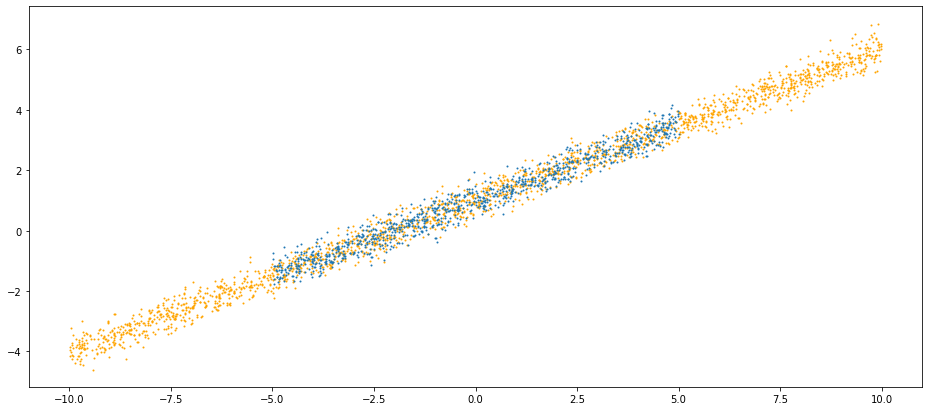

In [10]:

test_sort = torch.argsort(x_test.squeeze())
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="orange", s=1)
plt.scatter(x_train.squeeze(), y_train, s=1)

In [11]:
#net = nn.Sequential(nn.Linear(1, 32), nn.ReLU(), nn.Linear(32, 32), nn.ReLU(), nn.Linear(32, 1))
#net = nn.Linear(1, 1)
net = nn.Sequential(nn.Linear(1, 10), nn.ReLU(), nn.Linear(10, 1))

In [12]:
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))

In [13]:
print(len(x_train))
#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=dist.Gamma(1.0, 1.0))
obs_model = tyxe.likelihoods.HomoskedasticGaussian(
            dataset_size=len(x_train), scale=dist.Gamma(torch.tensor(1.0), torch.tensor(1.0)))
#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=torch.tensor(0.1))

#obs_model = tyxe.likelihoods.LearnableGaussian(len(x_train), scale=5.0)
#obs_model = tyxe.likelihoods.HeteroskedasticGaussian(len(x_train))   #Må ha output 2d


likelihood_guide_builder = partial(
            tyxe.guides.AutoNormal, init_loc_fn=init_to_median, init_scale=0.01)
#likelihood_guide_builder = None


1000


In [14]:
#guide_builder = poutine.block(partial(tyxe.guides.AutoNormal, init_scale=0.01), hide=["likelihood._scale"])
guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)

In [15]:
bnn = tyxe.bnn.VariationalBNN(net, prior, obs_model, guide_builder, likelihood_guide_builder=likelihood_guide_builder)

In [16]:
obs_model._scale
trace = poutine.trace(bnn.guide).get_trace(torch.randn(1))
scale = poutine.replay(poutine.trace(bnn.likelihood.get_scale), trace=trace)()
print(trace.nodes["likelihood_guide.likelihood._scale.loc"]["value"])
print(trace.nodes["likelihood_guide.likelihood._scale.scale"]["value"])
print(trace.nodes["likelihood._scale"]["value"])
scale

Parameter containing:
tensor(-0.1000, requires_grad=True)
tensor(0.0100, grad_fn=<AddBackward0>)
tensor(0.9123, grad_fn=<AddBackward0>)


tensor(0.9123, grad_fn=<AddBackward0>)

In [17]:
M = 100
N = 0
(2**(M - N)) / (2**(M) - 1)

1.0

In [18]:
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-4, "betas": (0.90, 0.999)})
elbos = []
def callback(bnn, i, e):
    if i % 100 == 0:
        print("epoch: {} | elbo: {}".format(i, e))
    elbos.append(e)

with tyxe.poutine.local_reparameterization():
    bnn.fit(train_dataloader, optim, 400, callback, num_particles=5, KL_annealing=False)

epoch: 0 | elbo: 1892.2835205078125
epoch: 100 | elbo: 1522.3302673339845
epoch: 200 | elbo: 1284.6492980957032
epoch: 300 | elbo: 1108.7887268066406


In [19]:
#pickle.dump(bnn, open(f"{BASE_DIR}/models/{NAME}.pkl", "wb"))

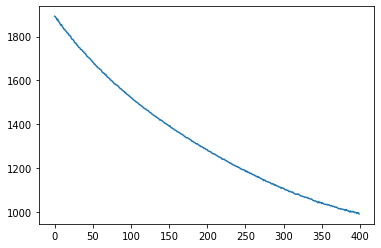

In [20]:
plt.plot(elbos)

In [21]:
trace = poutine.trace(bnn.guide).get_trace(x_test[0], y_test[0])

In [22]:
train_sort = torch.argsort(x_train.squeeze())
preds = bnn.predict(x_train[train_sort], num_predictions=1000, aggregate=True)

# For homoskedastic aggregate True
means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8191)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8251)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8252)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8254)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8286)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8227)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8173)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8174)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8207)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8160)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8271)
Parameter containing:
tensor(-0.

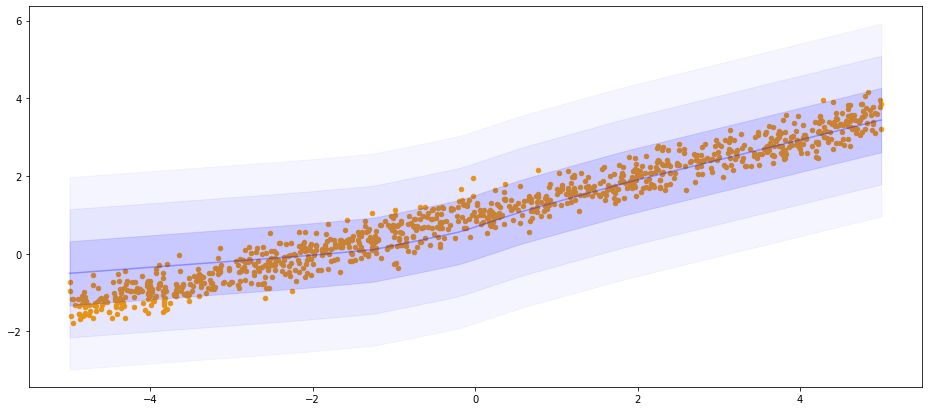

In [23]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_train, y_train, color="orange", s=20, alpha=1.0)
plt.plot(x_train[train_sort], means, color="blue", alpha=0.3)
for c in range(1, 4):
    plt.fill_between(x_train[train_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.5/c) * 0.08, color="blue")

In [24]:
test_sort = torch.argsort(x_test.squeeze())
preds = bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=True)

# For homoskedastic aggregate True
means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8073)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8235)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8291)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8161)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8213)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8321)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8122)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8256)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8247)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8326)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8254)
Parameter containing:
tensor(-0.

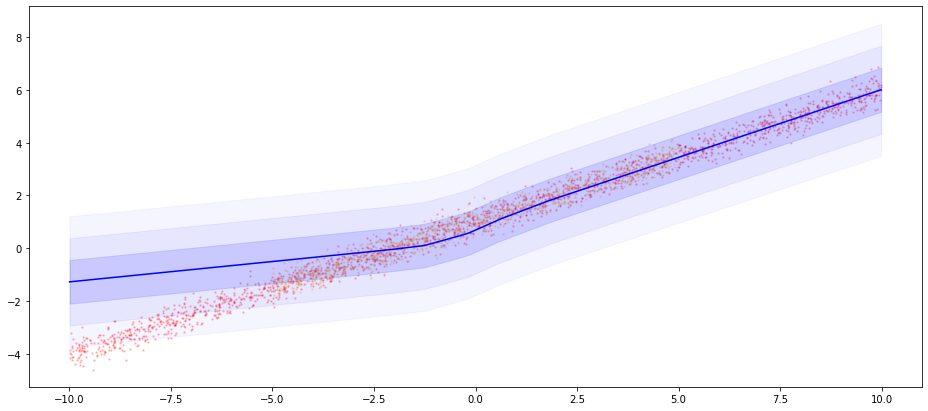

In [25]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
plt.plot(x_test[test_sort], means, color="blue")
#plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
for c in range(1, 4):
    plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.5/c) * 0.08, color="blue")

Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8221)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8115)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8326)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8071)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8286)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8164)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8124)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8231)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8121)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8181)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8191)
Parameter containing:
tensor(-0.

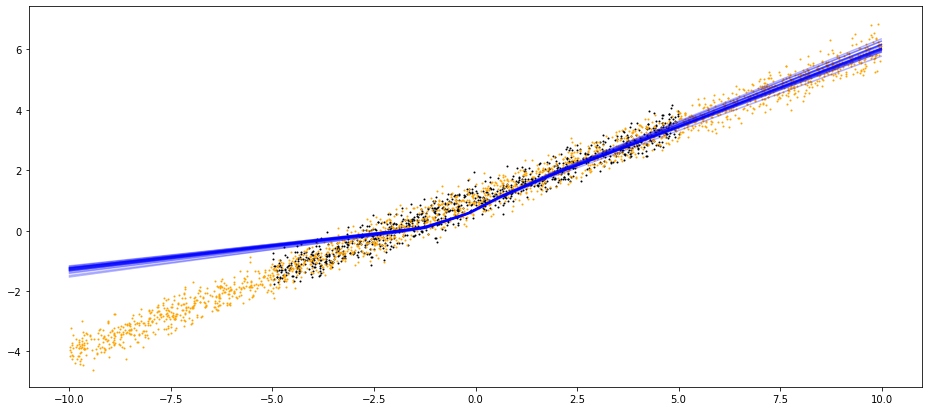

In [26]:


sampled_predictions = bnn.predict(x_test[test_sort], num_predictions=25, aggregate=False)
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_train, y_train, color="black", s=1)
plt.scatter(x_test[test_sort], y_test[test_sort], color="orange", s=1)
for yhat in sampled_predictions:
    plt.plot(x_test[test_sort], yhat, color="blue", alpha=0.3)

In [27]:
bnn.get_error_metrics(x_train, y_train, num_predictions=100, reduction="mean")

Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8133)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8258)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8165)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8270)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8249)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8223)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8362)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8309)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8363)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8315)
Parameter containing:
tensor(-0.1942, requires_grad=True)
tensor(0.0107)
tensor(0.8081)
Parameter containing:
tensor(-0.

(tensor(0.1874), tensor(-0.8635), tensor(0.3408))